In [2]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys
import pandas as pd
import seaborn as sb
from sklearn import metrics
from IPython.display import display
sb.set()

In [3]:
# %load full_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]

# Make the Datasets

just_right = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 0].drop("kepoi_name",axis=1).copy()
too_hot = goldilocks_dataset[goldilocks_dataset["gold_temp"] == 1].drop("kepoi_name",axis=1).copy()
too_cold = goldilocks_dataset[goldilocks_dataset["gold_temp"] == -1].drop("kepoi_name",axis=1).copy()

# Split into X and Y

jrX = just_right.drop(["koi_teq", "gold_temp"], axis=1).copy()
jrY = just_right["gold_temp"]

thX = too_hot.drop(["koi_teq", "gold_temp"], axis=1).copy()
thY = too_hot["gold_temp"]

tcX = too_cold.drop(["koi_teq", "gold_temp"], axis=1).copy()
tcY = too_cold["gold_temp"]

from sklearn.model_selection import train_test_split

# Splitting the hot/cold/right arrays into test and train data
hotX_train, hotX_test, hotY_train, hotY_test = train_test_split(thX, thY, random_state=1)
coldX_train, coldX_test, coldY_train, coldY_test = train_test_split(tcX, tcY, random_state=1)
rightX_train, rightX_test, rightY_train, rightY_test = train_test_split(jrX, jrY, random_state=1)

# Concatenating and reordering the testing and training data

# Testing
testingX = pd.concat([hotX_test, coldX_test, rightX_test])
testingY = pd.concat([hotY_test, coldY_test, rightY_test])
testingX = testingX.reindex(testingX.index.sort_values())
testingY = testingY.reindex(testingY.index.sort_values())

# Training
trainingX = pd.concat([hotX_train, coldX_train, rightX_train])
trainingY = pd.concat([hotY_train, coldY_train, rightY_train])
trainingX = trainingX.reindex(trainingX.index.sort_values())
trainingY = trainingY.reindex(trainingY.index.sort_values())


Is Lightkurve installed?

/home/jdowzell/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:228: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn('Warning: {} files available to download. '
/home/jdowzell/anaconda3/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)


<AxesSubplot:xlabel='Phase', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

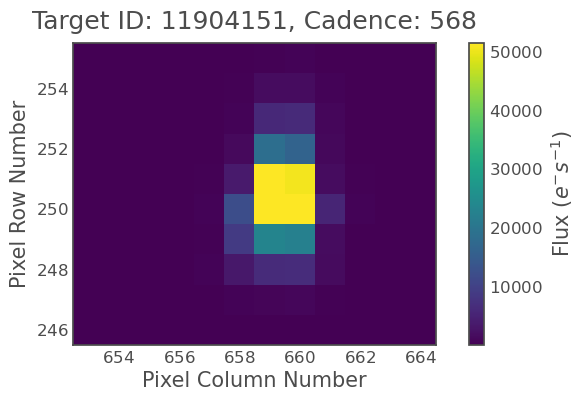

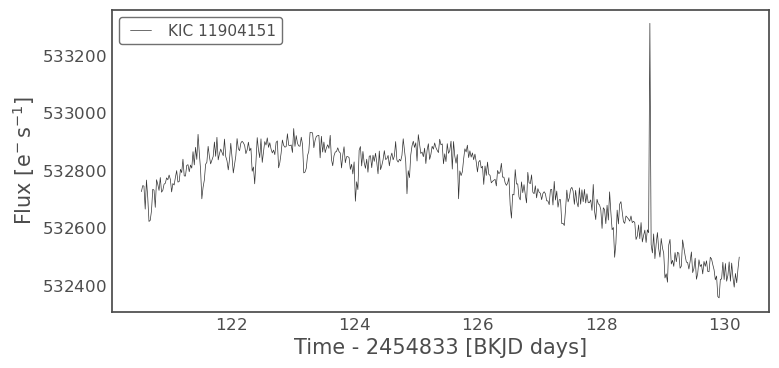

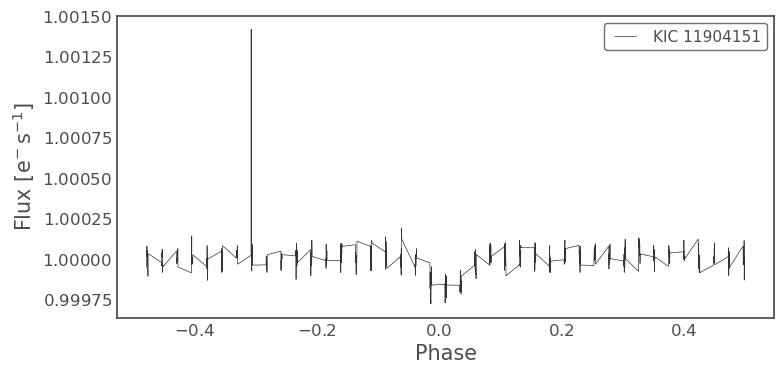

In [5]:
import lightkurve as lk
pixels = lk.search_targetpixelfile("Kepler-10").download()
pixels.plot()

lightcurve = pixels.to_lightcurve()
lightcurve.plot()

exoplanet = lightcurve.flatten().fold(period=0.838)
exoplanet.plot()

Useful, but not what I need to do.

What I *need* is to be able to download thousands of light curves so that I can run image analysis on them -- which means I need a way to *find* them.

Investigating the Lightkurve API, I see there is the following command:

`
lightkurve.search.search_tesscut(target, sector=None)
`

Searches MAST for TESS Full Frame Image cutouts containing a desired target or region.

This feature uses the TESScut service provided by the TESS data archive at MAST. If you use this service in your work, please cite TESScut in your publications.

Parameters:
**target:** `str`, `int`, or `astropy.coordinates.SkyCoord` object

Target around which to search. Valid inputs include:

-The name of the object as a string, e.g. “Kepler-10”.<br>
-The KIC or EPIC identifier as an integer, e.g. 11904151.<br>
-A coordinate string in decimal format, e.g. “285.67942179 +50.24130576”.<br>
-A coordinate string in sexagesimal format, e.g. “19:02:43.1 +50:14:28.7”.<br>
-An `astropy.coordinates.SkyCoord` object.<br>

**sector:** `int` or `list`
TESS Sector number. Default (None) will return all available sectors. A list of desired sectors can also be provided.

Returns:
**result:** SearchResult object
Object detailing the data products found.

The part that I think would be most useful will be the "
//ra=102.7 dec=-70.50 radius=1m

In [6]:
lk.search_tesscut("102.7 -70.5")

#,observation,target_name,productFilename,distance
0,TESS Sector 2,102.7 -70.5,TESSCut,0.0
1,TESS Sector 3,102.7 -70.5,TESSCut,0.0
2,TESS Sector 4,102.7 -70.5,TESSCut,0.0
3,TESS Sector 5,102.7 -70.5,TESSCut,0.0
4,TESS Sector 6,102.7 -70.5,TESSCut,0.0
5,TESS Sector 7,102.7 -70.5,TESSCut,0.0
6,TESS Sector 8,102.7 -70.5,TESSCut,0.0
7,TESS Sector 9,102.7 -70.5,TESSCut,0.0
8,TESS Sector 10,102.7 -70.5,TESSCut,0.0
9,TESS Sector 12,102.7 -70.5,TESSCut,0.0


In [16]:
lk.search_tesscut("285.67942179 +50.24130576")

#,observation,target_name,productFilename,distance
0,TESS Sector 14,285.67942179 +50.24130576,TESSCut,0.0
1,TESS Sector 15,285.67942179 +50.24130576,TESSCut,0.0
2,TESS Sector 26,285.67942179 +50.24130576,TESSCut,0.0
